# Detecção de Fraudes: Modelagem

In [15]:
# nossa variável alvo é a 'fraud'
# 1 em caso de fraude, 0 caso contrário

X = df.drop('fraude', axis=1).values
y = df['fraude'].values

# separando 70% para treino e 30% para teste

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=.3,
    shuffle=True,
    random_state=42,
    stratify=y
)

X_train.shape, y_train.shape

((199364, 30), (199364,))

### K-Fold Estratificada

In [16]:
# separação em 10 folds

skf = StratifiedKFold(
    n_splits=10, 
    shuffle=True,
    random_state=42
)

skf

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

## **ENGENHARIA DE FEATURES**

## **SELEÇÃO DE MODELOS**

In [22]:
# clf = LazyClassifier(
#     verbose=0,
#     ignore_warnings=True,
#     custom_metric=None
# )

# models, predictions = clf.fit(
#     X_train,
#     X_test,
#     y_train,
#     y_test
# )

# print(models)

## **SELECIONANDO OS TOP(n) MODELOS**

### Avaliando os modelos com cross-validation

In [23]:
def cross_validate_model(model, kfold, X, y, n_folds=10):
    index = ['precision', 'recall', 'f1-score', 'support']
    columns = ['0', '1', 'accuracy', 'macro avg', 'weighted avg']

    df_results = pd.DataFrame(
        data=np.zeros((len(index), len(columns))),
        index=index,
        columns=columns
    )

    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = model()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)

        df_results += pd.DataFrame(
            classification_report(
                y_val,
                y_pred,
                output_dict=True
            )
        )
    
    df_results /= n_folds
    return df_results

In [24]:
cross_validate_model(
    model=LGBMClassifier,
    kfold=skf,
    X=X_train,
    y=y_train
)

,0,1,accuracy,macro avg,weighted avg
precision,1.00,0.22,0.99,0.61,1.00
recall,0.99,0.47,0.99,0.73,0.99
f1-score,1.00,0.28,0.99,0.64,1.00
support,19902.00,34.40,0.99,19936.40,19936.40


### Selecionando o melhor modelo

## **LIDANDO COM O DESBALANCEAMENTO**

In [25]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled.shape, y_resampled.shape

((398040, 30), (398040,))

In [26]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled,
    test_size=.1,
    shuffle=True,
    random_state=42,
    stratify=y_resampled
)

In [27]:
cross_validate_model(
    model=LGBMClassifier,
    kfold=skf,
    X=X_train_res,
    y=y_train_res
)

,0,1,accuracy,macro avg,weighted avg
precision,1.00,1.00,1.00,1.00,1.00
recall,1.00,1.00,1.00,1.00,1.00
f1-score,1.00,1.00,1.00,1.00,1.00
support,17911.80,17911.80,1.00,35823.60,35823.60


In [53]:
def ml_pipeline(model, 
                X_train, 
                X_test,
                y_train,
                y_test,
                params=None):
    if params:
        model = model(**params)
    else:
        model = model()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    y_proba_true = [i[1] for i in y_proba]

    return model, y_pred, y_proba

In [54]:
def evaluate_model(y_test, y_pred, y_proba):
    print(classification_report(y_test, y_pred))

    plot_roc(y_test, y_proba);
    plot_ks_statistic(y_test, y_proba);

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.67      0.78      0.72       148

    accuracy                           1.00     85443
   macro avg       0.83      0.89      0.86     85443
weighted avg       1.00      1.00      1.00     85443



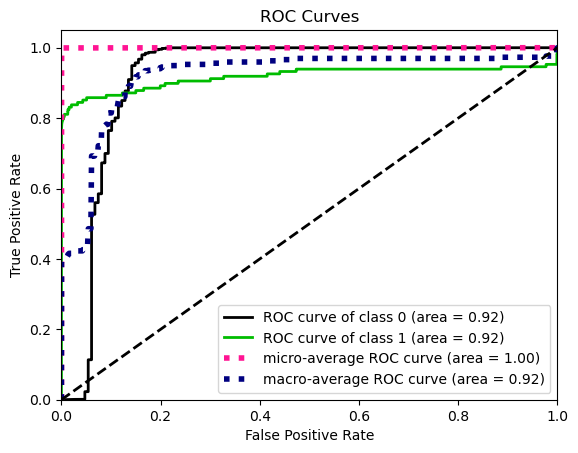

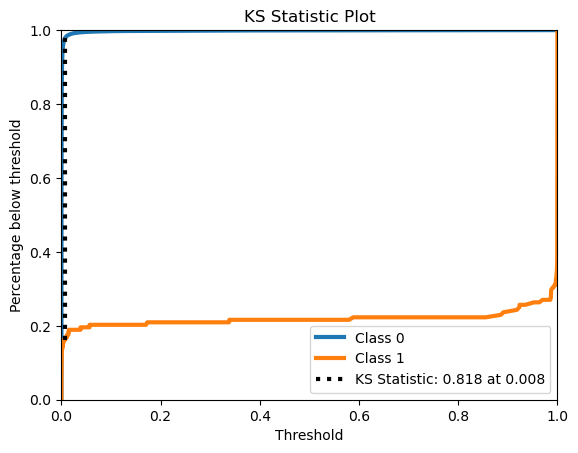

In [29]:
model, y_pred, y_proba = ml_pipeline(
    LGBMClassifier,
    X_train_res, 
    X_test, 
    y_train_res, 
    y_test
)

## **DETECÇÃO E TRATAMENTO DE OUTLIERS**

## **SELEÇÃO DE FEATURES**

## **CONDUÇÃO DE EXPERIMENTOS**

## **TUNAGEM DE HIPERPARÂMETROS**

### Otimização bayesiana

In [39]:
def objective(params):
    model = LGBMClassifier(boosting_type='gbdt', 
                               num_leaves=params[0], 
                               max_depth=params[1], 
                               learning_rate=params[2], 
                               n_estimators=params[3],
                               min_child_weight=params[4], 
                               subsample=params[5], 
                               colsample_bytree=params[6], 
                               reg_alpha=params[7], 
                               reg_lambda=params[8], 
                               random_state=42)
    model.fit(X_train_res, y_train_res)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)

    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    return -weighted_f1

space = [Integer(2, 100, name='num_leaves'),
         Integer(2, 20, name='max_depth'),
         Real(0.001, 1.0, name='learning_rate'),
         Integer(50, 500, name='n_estimators'),
         Real(0.1, 10.0, name='min_child_weight'),
         Real(0.1, 1.0, name='subsample'),
         Real(0.1, 1.0, name='colsample_bytree'),
         Real(0.0, 1.0, name='reg_alpha'),
         Real(0.0, 1.0, name='reg_lambda')]

result = gp_minimize(func=objective,
                     dimensions=space,
                     n_calls=50,
                     n_random_starts=10,
                     acq_func='EI',
                     xi=0.01,
                     verbose=1,
                     random_state=42)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.9988
Function value obtained: -0.9993
Current minimum: -0.9993
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.5136
Function value obtained: -0.9958
Current minimum: -0.9993
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.3788
Function value obtained: -0.9965
Current minimum: -0.9993
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.4362
Function value obtained: -0.9993
Current minimum: -0.9993
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.4863
Function value obtained: -0.9987
Current minimum: -0.9993
Iteration No: 6 started. 

In [48]:
print(result.space)
print(-result.fun)

Space([Integer(low=2, high=100, prior='uniform', transform='normalize'),
       Integer(low=2, high=20, prior='uniform', transform='normalize'),
       Real(low=0.001, high=1.0, prior='uniform', transform='normalize'),
       Integer(low=50, high=500, prior='uniform', transform='normalize'),
       Real(low=0.1, high=10.0, prior='uniform', transform='normalize'),
       Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
       Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
       Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
       Real(low=0.0, high=1.0, prior='uniform', transform='normalize')])
0.9994432751671705


In [49]:
best_params = {}
for i, name in enumerate(['num_leaves', 
                          'max_depth', 
                          'learning_rate', 
                          'n_estimators', 
                          'min_child_weight',
                          'subsample', 
                          'colsample_bytree', 
                          'reg_alpha', 
                          'reg_lambda']):
    best_params[name] = result.x[i]

best_params

{'num_leaves': 57,
 'max_depth': 15,
 'learning_rate': 0.07887978388924435,
 'n_estimators': 467,
 'min_child_weight': 1.5112382454651376,
 'subsample': 0.10078101474416162,
 'colsample_bytree': 0.7516540683273494,
 'reg_alpha': 0.1853945724204276,
 'reg_lambda': 0.2335822622993053}

In [56]:
model, y_pred, y_proba = ml_pipeline(
    LGBMClassifier,
    X_train_res, 
    X_test, 
    y_train_res, 
    y_test,
    best_params
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.81      0.82       148

    accuracy                           1.00     85443
   macro avg       0.92      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443



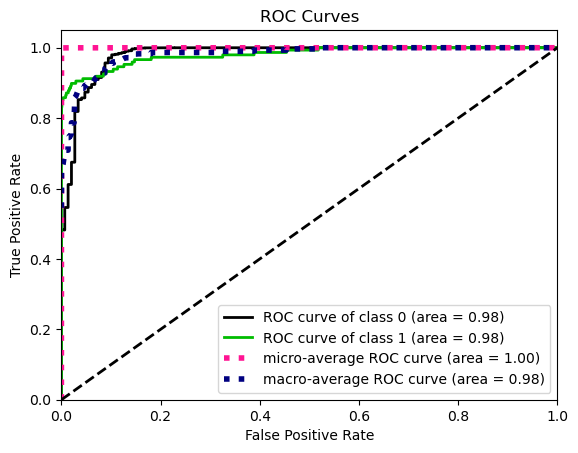

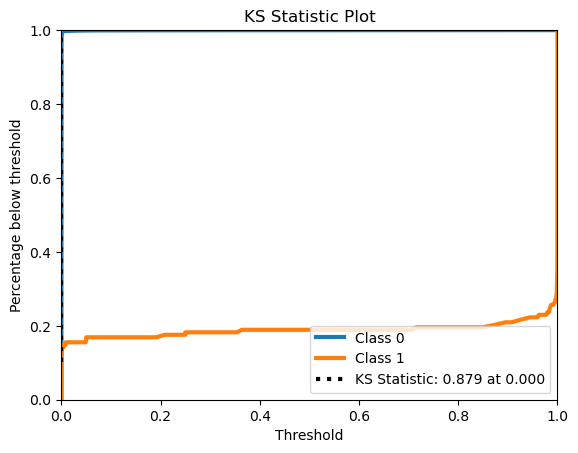

In [58]:
evaluate_model(y_test, y_pred, y_proba)

## **TESTANDO O MODELO FINAL**

### Testando com diferentes proporções (50, 60, 70, 80 e 90)

## **ESCOLHA DO THRESHOLD**

In [75]:
y_proba_true = [i[1] for i in y_proba]
y_thresh = [1 if i >= .88 else 0 for i in y_proba_true]

print(classification_report(y_test, y_thresh))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.80      0.84       148

    accuracy                           1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



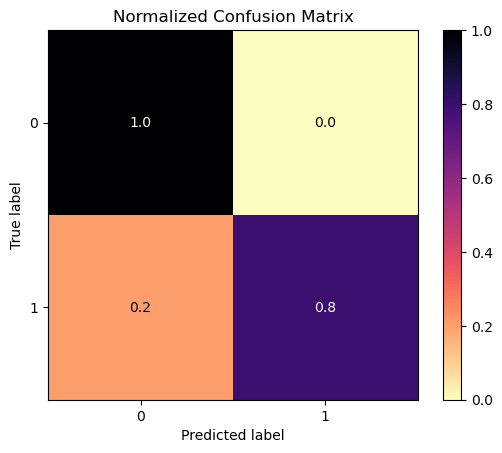

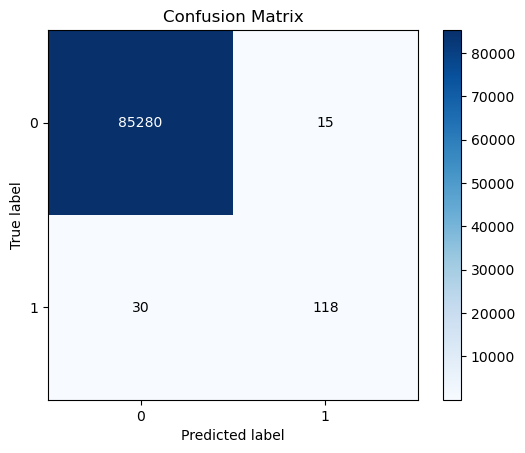

In [91]:
plot_confusion_matrix(y_test, y_thresh, normalize=True, cmap='magma_r');
plot_confusion_matrix(y_test, y_thresh);

## **SERIALIZAÇÃO DO MODELO**

In [30]:
# joblib.dump('model.sav', model)

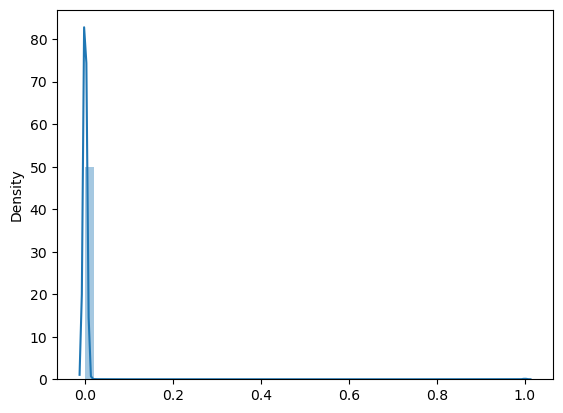

In [69]:
sns.distplot(y_proba_true);

In [ ]:
len(list(filter(lambda x: x!= 0, y_proba_true)))

308

In [ ]:
# y_thresh = np.where(np.array(y_proba_true) >= .99999, 1, 0)
y_thresh = [1 if i >= 1e-323 else 0 for i in y_proba_true]
print(classification_report(y_test, y_thresh))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     28432
           1       0.09      0.55      0.15        49

    accuracy                           0.99     28481
   macro avg       0.54      0.77      0.57     28481
weighted avg       1.00      0.99      0.99     28481



## **EXPLICABILIDADE DO MODELO**

## **CONSIDERAÇÕES FINAIS**